# database interface & plotting examples

In [1]:
%load_ext autoreload
%autoreload 2
import boto3
import base64
import os
from botocore.exceptions import ClientError
import json
import psycopg2
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pickle
import sys
import traceback
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
params = Utils.get_aws_secret("/secret/uav_db")
db, cur =  DB.connect(params)
del(params)
DB.get_tables(db)

[INFO] connecting to db.
[INFO] connected.


,table_name
0,model_tb
1,uav_tb
2,eqc_battery_tb
3,eq_motor_tb
4,degradation_parameter_tb
5,mission_tb
6,pg_stat_statements
7,battery_sensor_tb
8,flight_sensor_tb
9,experiment_tb


## get a list of experiments & mission_ids

In [6]:
experiments_df = DB.execute("""select et.* from experiment_tb et;""", database=db)

mission_ids = list(experiments_df['mission_ids'].values)
mission_ids = [idx.split('-') for idx in mission_ids]
mission_ids = [np.arange(int(x), int(y)) for x, y in mission_ids]
mission_idx = [np.arange(1, len(x)+1) for x in mission_ids]
assert len(mission_idx) == len(mission_ids), "[ERROR] index mappings should be of same length"
experiments = [(x, y) for x,y in zip(mission_ids, mission_idx)]
experiments[5][0]

array([527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539,
       540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552,
       553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565,
       566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578,
       579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591,
       592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604,
       605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617,
       618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629])

## access the mission and degredation data for a given experiment

In [7]:
experiment = 6 # 0 based
print(experiments_df['notes'].iloc[experiment])
mission_ids = experiments[experiment][0]
mission_idx = experiments[experiment][1]

mission_data_df = DB.execute(f"""select mt.* from mission_tb mt where mt.id >= {mission_ids[0]} and mt.id <= {mission_ids[-1]} order by mt.id asc;""", database=db)
mission_data_df['idx'] = mission_idx
mission_data_df = mission_data_df.drop(columns={'dt_start', 'dt_stop'})
mission_data_df.head()

simulating digital twin 4x, random trajectory exploration, digital twin does not inform true system, mission 742 (and others), why did true system fail when it had worse degradradation parameters than the digital twin? are there trajectories with higher crash rates? (trajectory 10)


,id,trajectory_id,stop_code,prior_rul,flight_time,distance,z_end,v_end,avg_pos_err,max_pos_err,std_pos_err,avg_ctrl_err,max_ctrl_err,std_ctrl_err,battery_id,uav_id,idx
0,631,14,3,18.0000,14.8288,1083.0743,0.5612,4.0129,1.3127,3.9425,0.8040,0.0875,3.8720,1.0319,2,1,1
1,632,14,3,18.0000,14.8288,1083.3425,0.5599,4.0123,1.3233,3.9342,0.7968,0.1252,3.9090,1.0319,2,1,2
2,633,14,3,18.0000,14.8288,1083.4338,0.5282,3.9930,1.3243,3.8746,0.7925,0.1165,3.8520,1.0365,2,1,3
3,634,11,3,18.0000,16.3563,1218.6216,0.5116,4.0238,1.3216,3.3685,0.7240,0.1979,3.5021,1.0057,2,1,4
4,635,15,3,18.4288,17.6350,1283.6089,0.4881,4.0144,1.2983,3.5001,0.8397,0.1234,3.5483,1.0409,2,1,5


### view summary statistics of the mission data

In [8]:
mission_data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,131.0,696.000000,37.960506,631.0000,663.50000,696.0000,728.50000,761.0000
trajectory_id,131.0,11.946565,2.954301,3.0000,10.00000,13.0000,14.00000,20.0000
stop_code,131.0,2.816794,0.508414,1.0000,3.00000,3.0000,3.00000,3.0000
prior_rul,131.0,16.613964,1.263457,13.7188,15.57330,17.0758,17.69250,18.5685
flight_time,131.0,14.790105,2.057571,1.0396,13.93420,14.8288,16.35630,19.6329
distance,131.0,1093.139221,147.703723,87.3520,1047.79255,1083.3364,1218.55020,1449.1421
z_end,131.0,0.517110,0.063170,0.4182,0.48805,0.5126,0.55095,0.9627
v_end,131.0,3.683755,0.438303,2.4711,3.48870,3.9057,3.99375,4.0377
avg_pos_err,131.0,1.336629,0.055145,1.2296,1.31875,1.3399,1.36310,1.7696
max_pos_err,131.0,3.740719,0.353017,3.1439,3.52835,3.6659,3.87080,5.1263


In [9]:
degradation_data_df = DB.execute(f"""select dpt.* from degradation_parameter_tb dpt where dpt.mission_id >= {mission_ids[0]} and dpt.mission_id <= {mission_ids[-1]} order by dpt.mission_id asc;""", database=db)
degradation_data_df = degradation_data_df.fillna(0)
degradation_data_df.head()

,id,mission_id,q_deg,q_var,q_slope,q_intercept,r_deg,r_var,r_slope,r_intercept,m_deg,m_var,m_slope,m_intercept,battery_id,motor2_id,uav_id
0,631,631,15.000000,0.90,0.0,0.0,0.001100,0.00100,0.0,0.0,0.237100,0.02000,0.0,0.0,2,2,1
1,632,632,15.000000,0.90,0.0,0.0,0.001100,0.00100,0.0,0.0,0.237100,0.02000,0.0,0.0,2,2,1
2,633,633,13.913262,0.89,0.0,0.0,0.001771,0.00099,0.0,0.0,0.251445,0.01975,0.0,0.0,2,2,1
3,634,634,14.897995,0.88,0.0,0.0,0.000586,0.00098,0.0,0.0,0.232806,0.01950,0.0,0.0,2,2,1
4,635,635,15.500000,0.87,0.0,0.0,0.000896,0.00097,0.0,0.0,0.216816,0.01925,0.0,0.0,2,2,1


## view summary statistics of the degradation data

In [10]:
degradation_data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,131.0,696.000000,37.960506,631.000000,663.500000,696.000000,728.500000,761.000000
mission_id,131.0,696.000000,37.960506,631.000000,663.500000,696.000000,728.500000,761.000000
q_deg,131.0,13.493197,1.257465,10.785498,12.545135,13.626380,14.561224,15.500000
q_var,131.0,0.417557,0.216912,0.200000,0.250000,0.260000,0.585000,0.900000
q_slope,131.0,-0.028664,0.051856,-0.163271,-0.060285,-0.032770,-0.003733,0.261229
q_intercept,131.0,15.278515,4.375167,0.000000,14.321135,15.567552,17.371333,22.736088
r_deg,131.0,0.013608,0.017023,0.000100,0.001694,0.005009,0.020550,0.064233
r_var,131.0,0.000419,0.000306,0.000100,0.000100,0.000360,0.000685,0.001000
r_slope,131.0,0.000422,0.000517,-0.000241,0.000043,0.000167,0.000800,0.001830
r_intercept,131.0,-0.031403,0.045675,-0.173827,-0.057739,-0.005386,0.000000,0.006323


## some data exploration
### looking at correlations between average position error and motor degradation

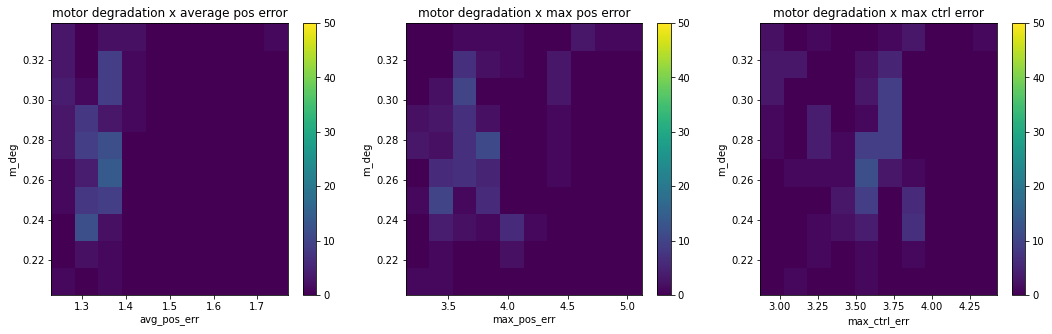

In [11]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.hist2d(mission_data_df['avg_pos_err'], degradation_data_df['m_deg'], bins=(10,10), vmax=50)
plt.colorbar()
plt.xlabel('avg_pos_err')
plt.ylabel('m_deg')
plt.title("motor degradation x average pos error")

plt.subplot(1,3,2)
plt.hist2d(mission_data_df['max_pos_err'], degradation_data_df['m_deg'], bins=(10,10), vmax=50)
plt.colorbar()
plt.xlabel('max_pos_err')
plt.ylabel('m_deg')
plt.title("motor degradation x max pos error")

plt.subplot(1,3,3)
plt.hist2d(mission_data_df['max_ctrl_err'], degradation_data_df['m_deg'], bins=(10,10), vmax=50)
plt.colorbar()
plt.xlabel('max_ctrl_err')
plt.ylabel('m_deg')
plt.title("motor degradation x max ctrl error")

plt.show()

### what about correlations with the degradation rate of change?

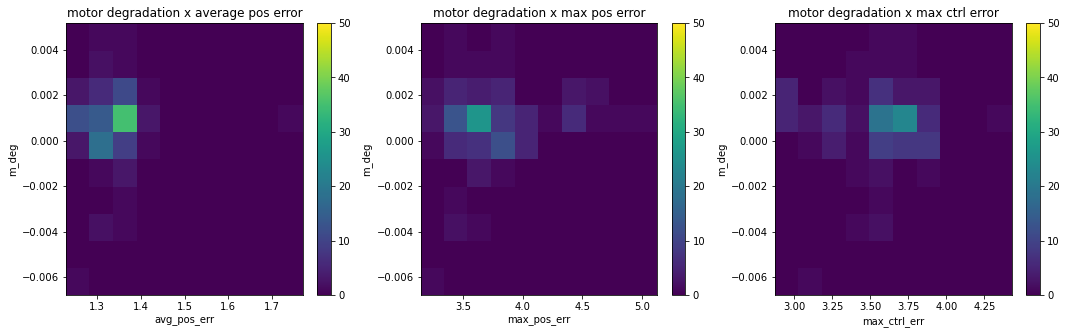

In [12]:
assert degradation_data_df['m_slope'].isnull().values.any() == False, "[WARN] fillna values on the m_slope column"
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.hist2d(mission_data_df['avg_pos_err'], degradation_data_df['m_slope'], bins=(10,10), vmax=50)
plt.colorbar()
plt.xlabel('avg_pos_err')
plt.ylabel('m_deg')
plt.title("motor degradation x average pos error")

plt.subplot(1,3,2)
plt.hist2d(mission_data_df['max_pos_err'], degradation_data_df['m_slope'], bins=(10,10), vmax=50)
plt.colorbar()
plt.xlabel('max_pos_err')
plt.ylabel('m_deg')
plt.title("motor degradation x max pos error")

plt.subplot(1,3,3)
plt.hist2d(mission_data_df['max_ctrl_err'], degradation_data_df['m_slope'], bins=(10,10), vmax=50)
plt.colorbar()
plt.xlabel('max_ctrl_err')
plt.ylabel('m_deg')
plt.title("motor degradation x max ctrl error")

plt.show()

### view feature distributions

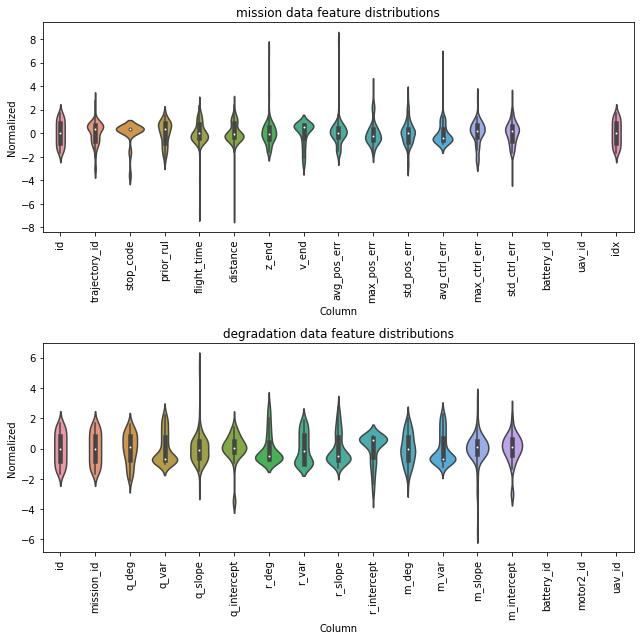

In [13]:
degradation_data_normalized = (degradation_data_df - degradation_data_df.mean()) / degradation_data_df.std()
mission_data_normalized = (mission_data_df - mission_data_df.mean()) / mission_data_df.std()

plt.figure(figsize=(9, 9))
plt.subplot(2,1,1)
mission_plt = mission_data_normalized.melt(var_name='Column', value_name='Normalized')
ax = sns.violinplot(x='Column', y='Normalized', data=mission_plt)
_ = ax.set_xticklabels(mission_data_df.keys(), rotation=90)
plt.title("mission data feature distributions")

plt.subplot(2,1,2)
degradation_plt = degradation_data_normalized.melt(var_name='Column', value_name='Normalized')
ax = sns.violinplot(x='Column', y='Normalized', data=degradation_plt)
_ = ax.set_xticklabels(degradation_data_df.keys(), rotation=90)
plt.title("degradation data feature distributions")
plt.tight_layout()

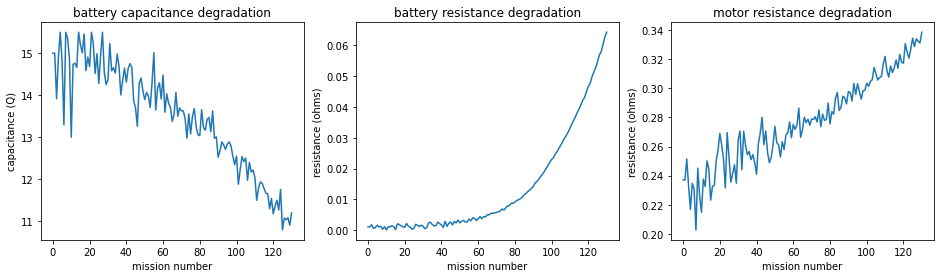

In [25]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
degradation_data_df['q_deg'].plot()
plt.title('battery capacitance degradation')
plt.xlabel('mission number')
plt.ylabel('capacitance (Q)')

plt.subplot(1,3,2)
degradation_data_df['r_deg'].plot()
plt.title('battery resistance degradation')
plt.xlabel('mission number')
plt.ylabel('resistance (ohms)')

plt.subplot(1,3,3)
degradation_data_df['m_deg'].plot()
plt.title('motor resistance degradation')
plt.xlabel('mission number')
plt.ylabel('resistance (ohms)')

plt.show()

In [37]:
# get the rul from each experiment
ruls = []
q_degs = []
r_degs = []
m_degs = []
errs = []

for i in range(0, len(experiments)):
    print(i, experiments_df['notes'].iloc[i])
    mission_ids = experiments[i][0]
    mission_idx = experiments[i][1]

    mission_data_df = DB.execute(f"""select mt.* from mission_tb mt where mt.id >= {mission_ids[0]} and mt.id <= {mission_ids[-1]} order by mt.id asc;""", database=db)
    mission_data_df['idx'] = mission_idx
    mission_data_df = mission_data_df.drop(columns={'dt_start', 'dt_stop'})
    
    degradation_data_df = DB.execute(f"""select dpt.* from degradation_parameter_tb dpt where dpt.mission_id >= {mission_ids[0]} and dpt.mission_id <= {mission_ids[-1]} order by dpt.mission_id asc;""", database=db)
    degradation_data_df = degradation_data_df.fillna(0)
    
    ruls.append(mission_data_df['prior_rul'].values)
    errs.append(mission_data_df['avg_pos_err'].values)
    q_degs.append(degradation_data_df['q_deg'].values)
    r_degs.append(degradation_data_df['r_deg'].values)
    m_degs.append(degradation_data_df['m_deg'].values)

0 first experiment with degradation curves downsampled to about 100 missions. motor degradation was too high
1 second experiment with motor degradation back to original (500 cycles) and battery degradation at half (180 cycles)
2 third experiment exact repeat of second experiment
3 4th experiment, allowed for better rul updates - still seeing true system failures before digital twin failures
4 failed to write flight data for mission 526, error during simulation, matlab crashed and the simulation restarted form scratch with a new experiment
5 now simulating digital twin 4x and using mean values, includes random trajectory exploration of path > rul time, stopped before experiment finished
6 simulating digital twin 4x, random trajectory exploration, digital twin does not inform true system, mission 742 (and others), why did true system fail when it had worse degradradation parameters than the digital twin? are there trajectories with higher crash rates? (trajectory 10)
7 same as above, dig

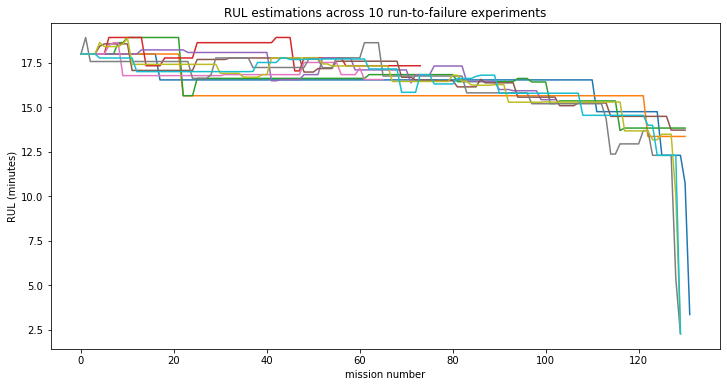

In [55]:
plt.figure(figsize=(12,6))
i = 0
for rul in ruls:
    if i == 0:
        i = 1
        continue
    plt.plot(rul)
    
plt.title("RUL estimations across 10 run-to-failure experiments")
plt.ylabel("RUL (minutes)")
plt.xlabel("mission number")
plt.show()

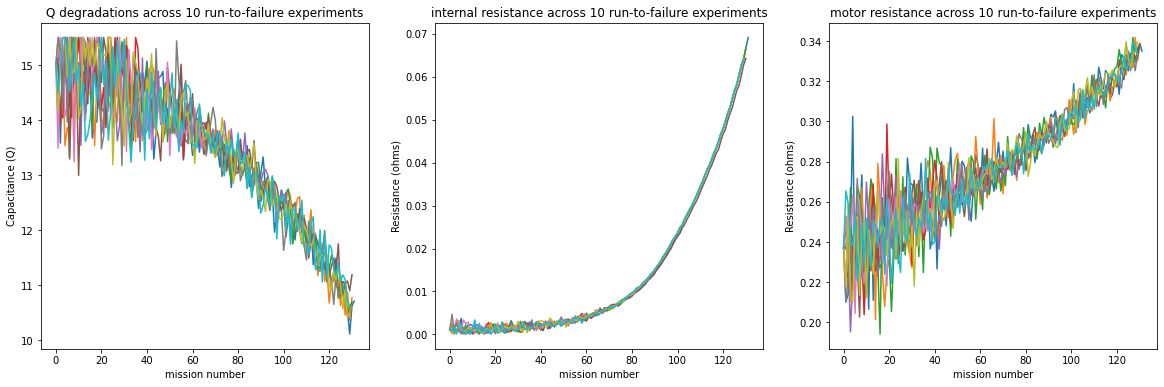

In [57]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
i = 0
for q in q_degs:
    if i == 0:
        i = 1
        continue
    plt.plot(q)
    
plt.title("Q degradations across 10 run-to-failure experiments")
plt.ylabel("Capacitance (Q)")
plt.xlabel("mission number")

plt.subplot(1,3,2)
i = 0
for r in r_degs:
    if i == 0:
        i = 1
        continue
    plt.plot(r)
    
plt.title("internal resistance across 10 run-to-failure experiments")
plt.ylabel("Resistance (ohms)")
plt.xlabel("mission number")

plt.subplot(1,3,3)
i = 0
for m in m_degs:
    if i == 0:
        i = 1
        continue
    plt.plot(m)
    
plt.title("motor resistance across 10 run-to-failure experiments")
plt.ylabel("Resistance (ohms)")
plt.xlabel("mission number")

plt.show()

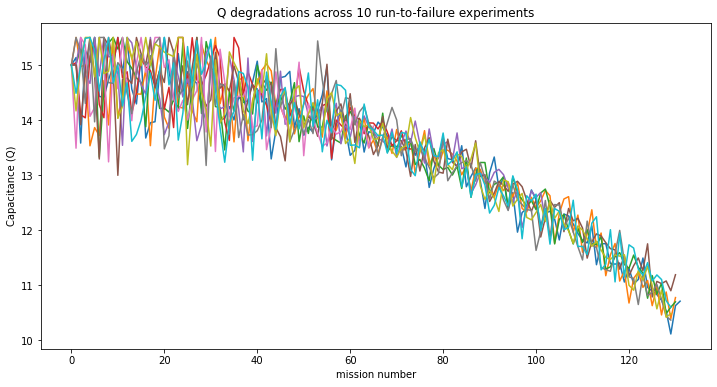

In [52]:
plt.figure(figsize=(12,6))
i = 0
for q in q_degs:
    if i == 0:
        i = 1
        continue
    plt.plot(q)
    
plt.title("Q degradations across 10 run-to-failure experiments")
plt.ylabel("Capacitance (Q)")
plt.xlabel("mission number")
plt.show()

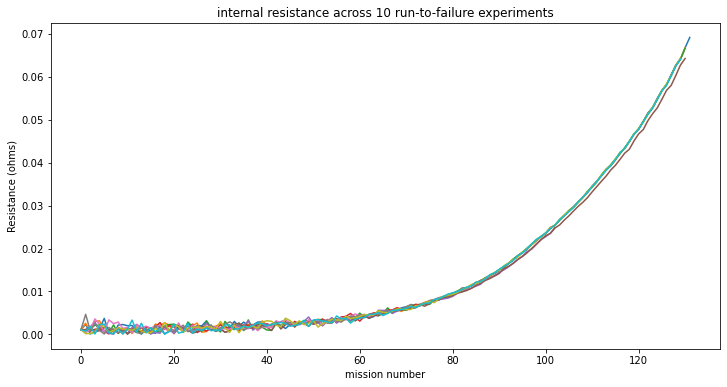

In [51]:
plt.figure(figsize=(12,6))
i = 0
for r in r_degs:
    if i == 0:
        i = 1
        continue
    plt.plot(r)
    
plt.title("internal resistance across 10 run-to-failure experiments")
plt.ylabel("Resistance (ohms)")
plt.xlabel("mission number")
plt.show()

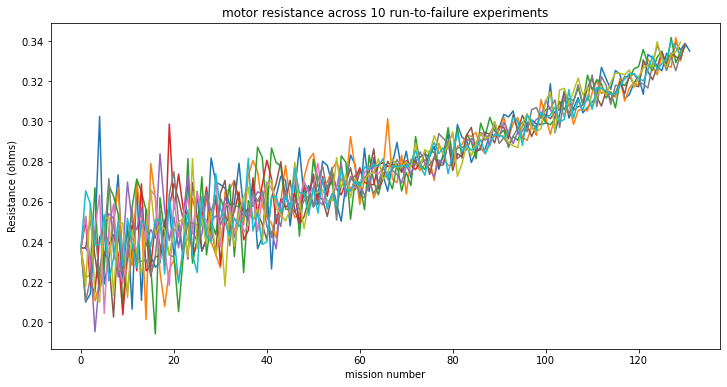

In [54]:
plt.figure(figsize=(12,6))
i = 0
for m in m_degs:
    if i == 0:
        i = 1
        continue
    plt.plot(m)
    
plt.title("motor resistance across 10 run-to-failure experiments")
plt.ylabel("Resistance (ohms)")
plt.xlabel("mission number")
plt.show()

In [16]:
twin_params_df = DB.execute("""select tpt.* from twin_params_tb tpt;""", database=db)
twin_params_df.head()

,id,mission_id,trajectory_id,rul_hat,flight_time,distance,v_end,z_end,avg_err,q_deg,r_deg,m_deg,stop1,stop2,stop3,uav_id
0,1,632,15,18.0,17.629167,1303.046960,4.016292,0.439171,1.553626,0.000750,14.038017,0.220910,0,0,1,1
1,2,632,15,18.0,17.627500,1303.772510,3.989719,0.493555,1.544319,0.001844,15.500000,0.243604,0,0,1,1
2,3,633,15,18.0,17.629167,1303.854756,4.001644,0.484169,1.534668,0.001424,15.267435,0.220493,0,0,1,1
3,4,633,15,18.0,17.626667,1303.435198,3.992516,0.493948,1.530990,0.001730,15.500000,0.259483,0,0,1,1
4,5,633,15,18.0,17.630000,1303.538439,4.017688,0.476507,1.557721,0.000750,15.057841,0.213596,0,0,1,1


In [4]:
class DB:
    """database interface class"""
    @staticmethod
    def connect(params: dict) -> [psycopg2.extensions.connection, psycopg2.extensions.cursor]:
        """
            @brief: connects to the database

            @params:
                params: dictionary of db connection parameters

            @returns:
                db: the database
                cur: the cursor
        """
        if "datasource.username" in params:
            temp = {
                "user": params["datasource.username"],
                "password": params["datasource.password"],
                "database": params["datasource.database"],
                "host": params["datasource.url"],
                "port": params["datasource.port"]
            }
            params = temp
        try:
            print("[INFO] connecting to db.")
            db = psycopg2.connect(**params)
            print("[INFO] connected.")
            cur = db.cursor()
        except Exception as e:
            print("[ERROR] failed to connect to db.")
            print(e)
            return []
        return [db, cur]

    @staticmethod
    def execute(sql_query: str, database: psycopg2.extensions.connection) -> pd.DataFrame:
        """
            @brief: shorthand sql style execution

            @params:
                sql_query: the query string to execute
                database: the database to execute on

            @returns: a pandas table of the query results
        """
        try:
            # print(f"[INFO]: {sql_query}")
            # print(f"[INFO]: {database}")
            if('insert' in sql_query):
                print("insert here")
                pd.read_sql_query(sql_query, database)
            else:
                return pd.read_sql_query(sql_query, database)
        except Exception as e:
            print(e)
            print(traceback.print_exc())
            if ('NoneType' in str(e)):
                print("ignoring error")
            return pd.DataFrame()
        
    @staticmethod
    def get_tables(db: psycopg2.extensions.connection) -> pd.DataFrame:
        """Returns a DataFrame of the tables in a given database"""
        return DB.execute("""SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'""", db)

    @staticmethod
    def get_fields(tb: str, db: psycopg2.extensions.connection) -> pd.DataFrame:
        """Returns the fields (column headers) for a given table"""
        return DB.execute("""SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE table_name = '{}';""".format(tb), db)


In [3]:
class Utils:
    """
        @brief: static class for utility functions

        @definitions:
            get_aws_secret(secret_name, region_name)
    """

    @staticmethod
    def get_aws_secret(secret_name: str="", region_name: str="us-east-1") -> {}:
        """
            @brief: retrieves a secret stored in AWS Secrets Manager. Requires AWS CLI and IAM user profile properly configured.

            @input:
                secret_name: the name of the secret
                region_name: region of use, default=us-east-1

            @output:
                secret: dictionary
        """
        client = boto3.session.Session().client(service_name='secretsmanager', region_name=region_name)
        secret = '{"None": "None"}'
        if (len(secret_name) < 1):
            print("[ERROR] no secret name provided.")
        else:
            try:
                res = client.get_secret_value(SecretId=secret_name)
                if 'SecretString' in res:
                    secret = res['SecretString']
                elif 'SecretBinary' in res:
                    secret = base64.b64decode(res['SecretBinary'])
                else:
                    print("[ERROR] secret keys not found in response.")
            except ClientError as e:
                print(e)

        return json.loads(secret)

    @staticmethod
    def get_config(filename: str=r'', section: str='postgresql') -> {}:
        """
            @brief: [DEPRECIATED] parses a database configuration file

            @params:
                filename: configuraiton file with .ini extension
                section: the type of db

            @returns:
                config: dictionary of database configuration settings
        """
        from configparser import ConfigParser
        parser = ConfigParser()
        config = {}

        try:
            parser.read(filename)
        except:
            print("[ERROR] failed to read file. does it exist?")
            return config

        if parser.has_section(section):
            params = parser.items(section)
            for param in params:
                config[param[0]] = param[1]
        else:
            print('[ERROR] Section {0} not found in the {1} file'.format(section, filename))
            return config

        return config
